# Hamiltonian Monte Chain - exercise 05
 >__Created__:  2018 Harrison B. Prosper

The standard approach in machine learning is to search for a single optimal function within the specified function space by minimizing the average loss. In the Bayesian approach, the task is construed as a problem of *inference* in which the goal is to assign a *probability density* to every function in the function space. The higher the probability density, the better the choice of function. But, the crucial point is that one is not obliged to use only one function. In principle, one can use all of them provided that results are weighted by the probability densities associated with the functions. In practice, of course, we use a finite sample of functions. 

The basic idea in Bayesian inference is to assign such probability densities (or probabilities) using Bayes theorem

$$ \boxed{\, p(w \, | \, D) = \frac{p(D \, | \, w) \, \pi(w)}{p(D)}\,}$$

The function $p(D \, | \,w)$ is called the __likelihood function__ or likelihood for short. It is the probability
model $p(x \, | \,w)$ of *potential* data $x$ evaluated at the actual data $D$. Since $D$ are constants, the likelihood is a function of the parameters $w$ only. The function $\pi(w)$ is called the prior density of __prior__ for short. It models what is known, or assumed, about $w$ independently of the data $D$. Bayes theorem reminds us of the impossibility of arriving at a satisfactory solution without making *some* assumptions. The assumptions are encoded both within the likelihood and especially the prior. The function $p(w \, | \, D)$ is called the __posterior density__.

Given a flexible function $n(x, w)$, we can compute, for example, its moments

$$n_{m}(x) = \int n^m(x, w) \, p(w \, | \, x) \, dw, $$

which  can be used to assign an uncertainty to $n(x, w)$, e.g. $\sigma = \sqrt{n_2 - n_1^2}$.
In this example, $n(x, w)$ will be a 2-hidden layer deep neural network.

### Markov Chain Sampling
In practice, integrals such as $$\int n^m(x, w) \, p(w \, | \, x) \, dw,$$ must be approximated. However, numerical integration is out of the question because the dimensionality of the $w$ is too large. We can try to approximate $p(w \, | \, x)$ by a giant multivariate Gaussian, but that approximation may not be good enough. The method of choice for truly hard problems is to *sample* points $w_i$ from some known probability density $f(w)$, for which sampling is easy, and approximate the integral
by the average

$$n_{m}(x) \approx \frac{1}{N} \sum_{n=1}^ n(x, w_n) \left[\frac{p(w_n \, | \, D}{f(w_n)} \right].$$

Ideally, we would like to have $f(w) = p(w \, | \, D)$ in order to achieve maximum accuracy. But, sample from $p(w \, | \, D)$ directly is also a hard problem! The method of choice to solve it is Hamiltonian Monte Carlo (HMC), which is a variant of Markov chain Monte Carlo (MCMC) well-suited to very difficult sampling problems.

The basic idea of HMC is to map the problem of sampling from $p(w \, | \, D)$ to the problem of sampling the states $(q, p)$ of a particle moving in a potential $U(q)$ with kinetic energy $K(p)$, where $q$ and $p$ are the position and momentum of the particle, respectively. The states are sampled from the probability density

$$g(q, p) \propto \exp(-H(q, p) / T),$$

where $H(q, p) = U(q) + K(p)$ is the __Hamiltonian__ of the system and $T$ the absolute temperature. The mapping is achieved by identifying $q \equiv w$ as the position and $p \equiv (dw/dt)/m$ as the momentum and

$$U(q) = - \ln p(w \, | \, D).$$

In statistical mechanics, the probability density $g(q, p)$ determines the thermodynamic 
properties of the system. Of course, we should really place things like position in quotes because the system is fictitious!

Given a particle's Hamiltonian, its motion in classical physics can be computed using Hamilton's
equations

\begin{align*}
    \frac{dq}{dt} & = \frac{\partial H}{\partial p},\\
    \frac{dp}{dt} & = -\frac{\partial H}{\partial q}.\\
\end{align*}

These equations are just Newton's laws of motion in disguise!

#### Hamiltonian Monte Carlo

In order to sample from $\exp(-H(q, p) / T)$, the "particle" must move deterministically according to Hamiliton's equations along a finite
trajectory. Then we randomly change its "momentum", which changes the value of $H(q, p)$. We then decide whether the current state $(q, p)$ is to be accepted or rejected. If it is rejected, we go back to the start of the trajectory and try again. If the state is accepted, we continue with the new momentum along another trajectory. The process is iterated for as many steps as needed to create a sample of points {(q_i, p_i)} whose distribution faithfully matches $\exp(-H(q, p) / T)$. The values $p_i$ are discarded and the $q_i$, that is, $w_i$ are kept.
The Hamilton equations are solved using a finite difference equation called the *leapfrog* algorithm. See below.


### Exercise
Implement the HMC algorithm for a 1-dimensional distribution $f(q)$.

  1. Choose a random starting value $q = q_0$. choose a step size $\epsilon$.
  3. Sample $p = p_0$ from a Gaussian of zero mean and some variance $\sigma$ (p = np.random.normal(0, 1))
  3. compute
    $$p = p(t) - \frac{\epsilon}{2} \, \frac{\partial U}{\partial q}(q(t))$$
  3. __for__ $i = 1\cdots L$ steps do:
  4. compute 
  \begin{align*}
  q & = q + \epsilon \, p\\
    & \textrm{if $i >= L - 1$ break}\\
  p & =  p - \epsilon \, \frac{\partial U}{\partial q}(q)
  \end{align*}
  4.  __endfor__
  5. compute
    $$p = p(t) - \frac{\epsilon}{2} \, \frac{\partial U}{\partial q}(q(t))$$
  6. compute
  \begin{align*}
  U_0 & = U(q_0)\\
  K_0 & = p_0^2 / 2\\
    U & = U(q)\\
    K & = p^2 / 2
  \end{align*}
  7. Now decide whether to accept or reject the next point
  8. $x$ = np.random.uniform(0,1)
  9. __if__ ( $x$ < exp($U_0 + K_0 - U - K$) __accept__ $q$ and save it __else__ set $q = q_0$
  
Steps 2 to 9 are repeated a large number of times (in the tens to hundreds of thousands) and one uses on the last few thousand points as the sample.

In [18]:
import os, sys
import pandas as pd
import numpy as np
import scipy.stats as st

import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline

In [13]:
# update fonts
FONTSIZE = 18
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 18}

mp.rc('font', **font)

In [28]:
x = np.random.uniform(0,1)
y = np.random.normal(0,1)
z = st.norm.pdf(np.arange(5),1)
print x, y, z

0.944769424827 1.07006704843 [ 0.24197072  0.39894228  0.24197072  0.05399097  0.00443185]


In [59]:
def function(q):
    p = 0.5*st.norm.pdf(q, 2.0, 0.7)+0.3*st.norm.pdf(q, 3.0, 0.2)+ 0.2*st.norm.pdf(q, 5.0, 0.5)
    return p

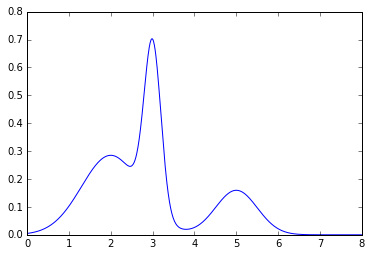

In [61]:
x = np.arange(0,8, 0.01)
y = function(x)
plt.plot(x,y);